## Multi Training Summary

This will read a series 'history.pkl' file that contains the training history of several models and hyperparameters

In [1]:
# Setup, run only once!
import os
import sys
sys.path.insert(0, '../')
os.chdir('..') # Make sure to only run this once!

In [2]:
import pickle
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style()
sns.set(font_scale=1.2)  # crazy big
# If the user has qgrid installed, then lets use it
try:
    from qgrid import show_grid
except:
    print('Using default Jupyter Dataframe...')
    def show_grid(df):
        return df

%matplotlib inline

In [3]:
def load_files(*args):
    " Loads a series of pickel files "
    history = {}
    for file in args:
        file_history = pickle.load( open(file, "rb" ) )
        history.update(file_history)
    return history
        

In [4]:
# Files holding the history of our tainign of models
file1 = "/media/jeremy/TOSHIBA EXT/Research/roof_learning/witten/models/multi_9_2_2017/inceptionv3_single_history.pkl"
file2 = "/media/jeremy/TOSHIBA EXT/Research/roof_learning/witten/models/multi_9_2_2017/vgg16_single_history.pkl"
file3 = "/media/jeremy/TOSHIBA EXT/Research/roof_learning/witten/models/multi_9_2_2017/resnet50_single_history.pkl"

# file_temp = "/media/jeremy/TOSHIBA EXT/Research/roof_learning/witten/models/multi_9_2_2017/vgg16_single_history.pkl"
history = load_files(file1, file2, file3)
# history = load_files(file_temp)
# history['inceptionv3_lr_1.0_fc1_100_fc2_100_layer_18_run_0_rgb']

### Organize the history into a compact Pandas Data Frame

In [5]:
def get_model_dict(model_name):
    model_tokens = model_name.split('_')
    
    values =  {
        'full_name': model_name,
        'model': model_tokens[0],
#         'lr': float(model_tokens[2]),
        'fc1': int(model_tokens[4]),
#         'fc2': int(model_tokens[6]),
        'layer': int(model_tokens[8]),
        'run': int(model_tokens[10]),
        'input': model_tokens[11]
    }
    return values

def get_best_accuracy(model_name, model):
    model_acc_list = model['val_acc']
    acc = max(model_acc_list)
    index_acc = model_acc_list.index(acc)
    loss = model['val_loss'][index_acc]
    train_acc = model['acc'][index_acc]
    acc_dict = {
        'train_acc': train_acc,
        'val_acc': acc,
        'val_loss': loss,
        'time': model['time']/60.0 if 'time' in model else ''
    }
    return acc_dict

def get_model_stats(model_name, model):
    model_dict = get_model_dict(model_name)
    acc_dict = get_best_accuracy(model_name, model)
    model_dict.update(acc_dict)
    return model_dict
    


In [11]:
model_dicts = [get_model_stats(key, value) for key,value in history.items()]
df = pd.DataFrame.from_dict(model_dicts)
df = df.sort_values('model')
# # df.index = df["full_name"]
# # df.index.name =  "Full Model Name"
# model_dicts
show_grid(df)
df.to_csv('results/multi_train.csv')

### Best  Models

In [7]:
inputs = df.input.unique()
if 'rgb' in inputs:
    best_rgb = df.loc[df[df.input == 'rgb']['val_acc'].idxmax()]
    print('Best RGB Model')
    pp(best_rgb)
    print('\n')

if 'lidar' in inputs:
    best_lidar = df.loc[df[df.input == 'lidar']['val_acc'].idxmax()]
    print('Best LIDAR Model')
    pp(best_lidar)


Best RGB Model
fc1                                                        100
full_name    resnet50_lr_1.0_fc1_100_fc2_100_layer_50_run_0...
input                                                      rgb
layer                                                       50
model                                                 resnet50
run                                                          0
time                                                   61.1364
train_acc                                             0.979268
val_acc                                               0.871046
val_loss                                              0.898371
Name: 6, dtype: object


Best LIDAR Model
fc1                                                        100
full_name    resnet50_lr_1.0_fc1_100_fc2_100_layer_50_run_0...
input                                                    lidar
layer                                                       50
model                                                 resnet5

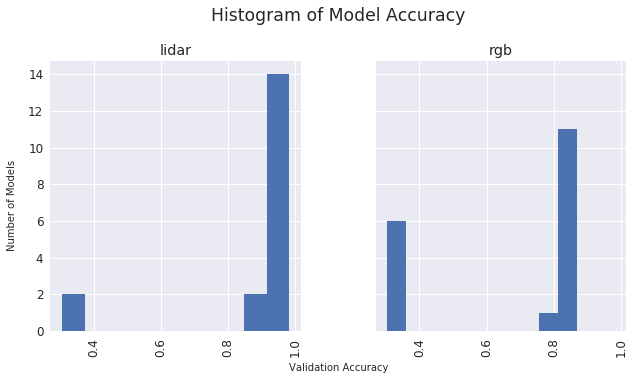

In [8]:
# set up figure & axes
sub_plot_num = len(df.input.unique())

fig, axes = plt.subplots(nrows=1, ncols=sub_plot_num, sharex=True, sharey=True,figsize=(5. * sub_plot_num,5.))
# drop sharex, sharey, layout & add ax=axes
df.hist(column='val_acc',by='input', ax=axes)

# set title and axis labels
plt.suptitle('Histogram of Model Accuracy', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Validation Accuracy', ha='center')
fig.text(0.04, 0.5, 'Number of Models', va='center', rotation='vertical')

## Scatter Bubble Plot

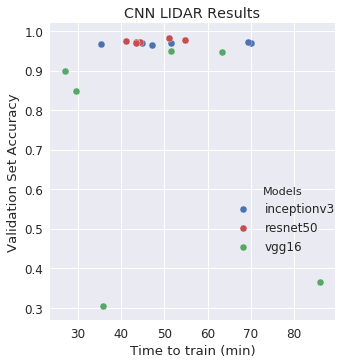

In [9]:
current_palette = sns.color_palette()
custom_pallete = {"inceptionv3": current_palette[0], "resnet50": current_palette[2], "vgg16": current_palette[1]}

df_lidar = df[df.input == 'lidar']
df_rgb = df[df.input == 'rgb']
ax = sns.pairplot(x_vars=['time'], y_vars=['val_acc'], data=df_lidar, hue="model", size=5, palette=custom_pallete)
#              plot_kws={"s": df['layer']})
ax._legend.set_title("Models")
ax._legend.set_bbox_to_anchor((.73, .4))
ax.set(xlabel='Time to train (min)', ylabel='Validation Set Accuracy', title='CNN LIDAR Results')
plt.savefig('results/cnn_lidar_results.eps')

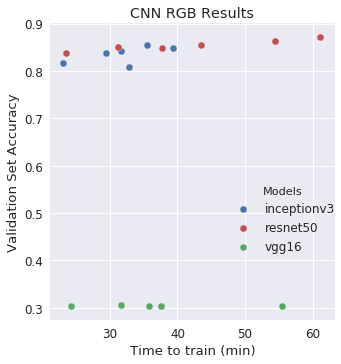

In [10]:
ax = sns.pairplot(x_vars=['time'], y_vars=['val_acc'], data=df_rgb, hue="model", size=5, palette=custom_pallete)
#              plot_kws={"s": df['layer']})
ax._legend.set_title("Models")
ax._legend.set_bbox_to_anchor((.73, .4))
ax.set(xlabel='Time to train (min)', ylabel='Validation Set Accuracy', title='CNN RGB Results')
plt.savefig('results/cnn_rgb_results.eps')